# **A. Introduction**

# **B. Approach**



## **1.   Setup Framework**


Before model training, it is essential to set up a robust evaluation framework to ensure that the model's performance is fairly and accurately assessed. This involves splitting the data into training, validation, and testing datasets. The training set is used to train the model, the validation set is used to tune hyperparameters, and the test set provides an unbiased evaluation of the model's performance.

**Rationale:** A typical split of 70% training, 15% validation, and 15% testing ensures sufficient data for training while preserving enough data to validate the model and assess generalization performance.

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import imageio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from pathlib import Path
from time import strftime
import uuid
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception, MobileNetV2

## **2. Connect data file**



*   ***Mounting Google Drive:*** The code uses drive.mount('/content/drive') to mount Google Drive into the Colab environment, enabling access to files stored in the cloud. This is essential for handling large datasets and persistent storage in a seamless and reliable way, commonly used in Colab for large-scale data analysis.

*   ***Setting the Data Path:*** The data_path variable specifies the location of the dataset in Google Drive. This makes the code more flexible and easier to maintain, as changes to the data location can be made by simply updating this variable.

*   ***Changing the Working Directory:*** Using os.chdir(data_path), the working directory is set to the specified data path. This allows for easier file handling by making all subsequent operations relative to this directory, reducing the need for full path specifications and minimizing errors.

*   ***Listing the Contents of the Current Directory:*** The command os.listdir() lists the files in the current directory, confirming that the working directory is set correctly and that the necessary data files are present. This step acts as a checkpoint before proceeding with further data processing.


## **3. Load CSV files**

The code loads two CSV files into Pandas DataFrames: train_data for training and future_data for future predictions. Besides, the 'FilePath' column is added to both DataFrames to store the full path to each image file. The paths are constructed by joining a common directory (image_dir) with the individual filenames from the FileName column. By that way, constructing full paths for each image ensures that the images can be easily accessed later, facilitating image loading for training and prediction. This approach centralizes file handling and ensures consistency, reducing the likelihood of errors when accessing image files.

In [4]:
train_data = pd.read_csv('train_data_2024.csv')
future_data = pd.read_csv('future_data_2024.csv')

image_dir = './Images/'
# Get all file paths of the images
train_data['FilePath'] = train_data['FileName'].apply(lambda x: os.path.join(image_dir, x))
future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join(image_dir, x))

In [3]:
future_data.head()

,FileName,FilePath
0,Img_1963.jpg,./Images/Img_1963.jpg
1,Img_7244.jpg,./Images/Img_7244.jpg
2,Img_6218.jpg,./Images/Img_6218.jpg
3,Img_7703.jpg,./Images/Img_7703.jpg
4,Img_6318.jpg,./Images/Img_6318.jpg


In [4]:
train_data.head()

,FileName,Class,MoreThanOnePerson,HighLevelCategory,FilePath
0,Img_460.jpg,blowing_bubbles,YES,Social_LeisureActivities,./Images/Img_460.jpg
1,Img_8152.jpg,blowing_bubbles,YES,Social_LeisureActivities,./Images/Img_8152.jpg
2,Img_9056.jpg,jumping,YES,Sports_Recreation,./Images/Img_9056.jpg
3,Img_3880.jpg,pushing_a_cart,YES,OutdoorActivities,./Images/Img_3880.jpg
4,Img_3168.jpg,writing_on_a_book,NO,Artistic_MusicalActivities,./Images/Img_3168.jpg


In [5]:
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

## **4. Preprocess the data**

By examining the number of distinct values in the 'Class' column, you ensure that the dataset is correctly labeled for training. If the result deviates from 40, it may indicate missing or extra classes that could impact model performance.

In addition to verifying the number of classes, it's important to note that the development data includes three labels: 'Class', 'MoreThanOnePerson', and 'HighLevelCategory', with 'FileName' being excluded from predictions. For the primary model, you only need to predict the 'Class' and 'MoreThanOnePerson' labels. The 'HighLevelCategory' label, although not necessary for the main prediction task, could be useful as an auxiliary output layer. Integrating 'HighLevelCategory' in this way might help in normalizing the model or improving its performance by providing additional contextual information.

In [6]:
# Verify if the quantity of classes aligns with the specifications by confirming that there are indeed 40 classes in total
train_data['Class'].nunique()

40

By counting the number of non-null entries in the 'FileName' column, this line provides the total count of data points available for training. This count is essential for understanding the size of your dataset and ensuring that you have enough instances to build and evaluate your model effectively.

In [7]:
# Check how many instances
train_data['FileName'].count()

4500

It is also important to note that the future_data does not contain any labels, rendering it unsuitable for evaluation purposes. As a result, the data from the train_data_2024.csv file will be used and split into training, testing, and validation datasets. Furthermore, it has been confirmed that the train data contains the correct number of unique classes, aligning with the model's requirements and ensuring that the dataset is appropriately structured for training and evaluation.

## **5. Validate Images**

In [8]:
# Check if any Filename overlap between 2 data file
train_data['FileName'].isin(future_data['FileName']).sum()

0

This count helps to detect potential data leakage, which occurs if the same images are present in both datasets. Ensuring that there are no overlapping filenames is crucial for maintaining the integrity of your training and evaluation processes, as it prevents the possibility of the model being inadvertently trained or tested on duplicate data.

In [9]:
# Get the size of an image given its filepath
def image_dimensions(filepath):
    image = imageio.imread(filepath)
    width, height = image.shape[1], image.shape[0]
    return width, height

# Check the sizes of all images listed in the 'FileName' column of a DataFrame
def get_image_sizes(data):
    # Initialize an empty list to store the image sizes
    image_sizes = []

    # Loop over each filename in the 'FileName' column of the data
    for filename in data['FileName']:
        # Construct the full path to the image file
        image_path = os.path.join('Images', filename)
        print(image_path)

        # Get the dimensions of the image
        dimensions = image_dimensions(image_path)

        # Append the dimensions to the list
        image_sizes.append(dimensions)

    return image_sizes

In [11]:
sizes = get_image_sizes(train_data)

Images\Img_460.jpg
Images\Img_8152.jpg
Images\Img_9056.jpg
Images\Img_3880.jpg
Images\Img_3168.jpg
Images\Img_8609.jpg
Images\Img_3838.jpg
Images\Img_1699.jpg
Images\Img_8543.jpg
Images\Img_1980.jpg
Images\Img_1312.jpg
Images\Img_4514.jpg
Images\Img_3866.jpg
Images\Img_1665.jpg
Images\Img_4231.jpg
Images\Img_8675.jpg
Images\Img_1137.jpg
Images\Img_5918.jpg
Images\Img_951.jpg
Images\Img_5516.jpg
Images\Img_8478.jpg
Images\Img_5152.jpg
Images\Img_2000.jpg
Images\Img_8656.jpg
Images\Img_5416.jpg
Images\Img_4513.jpg
Images\Img_1342.jpg
Images\Img_6016.jpg
Images\Img_7130.jpg
Images\Img_5929.jpg
Images\Img_911.jpg
Images\Img_2077.jpg
Images\Img_949.jpg
Images\Img_997.jpg
Images\Img_991.jpg
Images\Img_4408.jpg
Images\Img_3907.jpg
Images\Img_3098.jpg
Images\Img_7745.jpg
Images\Img_9239.jpg
Images\Img_1290.jpg
Images\Img_1018.jpg
Images\Img_5533.jpg
Images\Img_793.jpg
Images\Img_8428.jpg
Images\Img_2875.jpg
Images\Img_3195.jpg
Images\Img_2888.jpg
Images\Img_2537.jpg
Images\Img_6433.jpg
Images\

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9120\751675785.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


Images\Img_1976.jpg
Images\Img_9230.jpg
Images\Img_6052.jpg
Images\Img_6179.jpg
Images\Img_3330.jpg
Images\Img_7308.jpg
Images\Img_2997.jpg
Images\Img_7335.jpg
Images\Img_3346.jpg
Images\Img_5807.jpg
Images\Img_7114.jpg
Images\Img_601.jpg
Images\Img_3946.jpg
Images\Img_6979.jpg
Images\Img_4523.jpg
Images\Img_350.jpg
Images\Img_8600.jpg
Images\Img_2996.jpg
Images\Img_2845.jpg
Images\Img_7993.jpg
Images\Img_8009.jpg
Images\Img_7789.jpg
Images\Img_7978.jpg
Images\Img_3515.jpg
Images\Img_7544.jpg
Images\Img_8305.jpg
Images\Img_7225.jpg
Images\Img_8910.jpg
Images\Img_7042.jpg
Images\Img_7753.jpg
Images\Img_5402.jpg
Images\Img_2935.jpg
Images\Img_829.jpg
Images\Img_9068.jpg
Images\Img_4511.jpg
Images\Img_2220.jpg
Images\Img_6463.jpg
Images\Img_8826.jpg
Images\Img_4842.jpg
Images\Img_6339.jpg
Images\Img_5473.jpg
Images\Img_3382.jpg
Images\Img_9427.jpg
Images\Img_8237.jpg
Images\Img_8069.jpg
Images\Img_4669.jpg
Images\Img_2854.jpg
Images\Img_7497.jpg
Images\Img_1058.jpg
Images\Img_9419.jpg
Ima

The code snippet 'image_dimensions(filepath)' defines a function to retrieve the dimensions of an image given its file path. By using 'imageio.imread(filepath)', the function loads the image, and image.shape provides its width and height. The function returns these dimensions, which are essential for analyzing and ensuring consistency in image sizes within the dataset.

To check the sizes of all images listed in the 'FileName' column of a DataFrame, the function 'get_all_image_sizes(data)' is used. This function iterates over each filename, constructs the full path to the image using 'os.path.join('Images', filename)', and retrieves the image dimensions through the image_dimensions function. The sizes are then collected in a list. This approach allows you to systematically analyze the dimensions of all images in the dataset, which is crucial for preprocessing and ensuring that all images conform to the required specifications for model training.

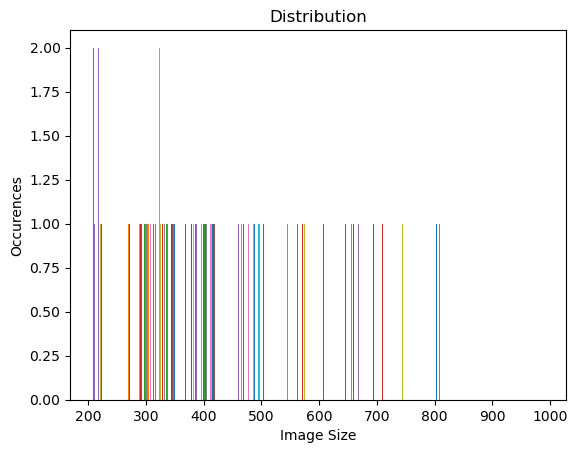

In [12]:
# Plot the sizes
plt.hist(sizes, bins=10)
plt.xlabel('Image Size')
plt.ylabel('Occurences')
plt.title('Distribution')
plt.show()

The plot illustrates the distribution of image sizes within your dataset. The following key points can be concluded:


*   **Sparse Distribution:** The histogram shows that the image sizes are sparsely distributed across different values. This is indicated by the tall, thin lines corresponding to individual image sizes, suggesting that there are not many images of the same size.

*   **No Common Image Size:** Unlike typical datasets where a peak or cluster might indicate a common or predominant image size, this dataset lacks such clustering. This could suggest significant variation in the dimensions of images.

*   **Implications for Preprocessing:**

  *   ***Resizing Required:*** Given the variety in image sizes, it's likely that resizing images to a uniform dimension will be necessary before feeding them into a deep learning model, especially we are planning to use a pre-trained Convolutional Neural Network (CNN).

  *   ***Memory and Performance Consideration:*** The variation in image sizes might also impact memory usage and processing time, making it even more important to standardize image dimensions.


*   **Outliers:** There might be outliers present with very large or very small dimensions compared to the rest. These should be handled carefully, as they can skew model training if not properly addressed.


















## **6. Check the Imbalance of Data**

The distribution of classes was considered, and techniques like class weighting or oversampling could be considered if significant imbalance is found.

To analyze the distribution of occurrences within the dataset, the code snippet 'grouped_counts = train_data.groupby(['Class', 'MoreThanOnePerson']).size().reset_index(name='Count')' groups the data by the 'Class' and 'MoreThanOnePerson' columns, then counts the number of occurrences for each combination. This grouping is useful for understanding how many instances fall into each class and whether they contain more than one person.

Following this, 'the pivot_table = grouped_counts.pivot(index='Class', columns='MoreThanOnePerson', values='Count').fillna(0)' reshapes the grouped data into a format suitable for plotting. By pivoting the table, you can create a stacked bar chart to visually represent the distribution of 'MoreThanOnePerson' within each 'Class'. The plotting code 'ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))' generates this chart, with 'ax.set_title()', 'ax.set_xlabel()', 'ax.set_ylabel()', and 'ax.set_xticklabels()' enhancing readability and presentation. The final result is a clear visualization showing how many images in each class involve more than one person, facilitating a better understanding of the dataset's composition.

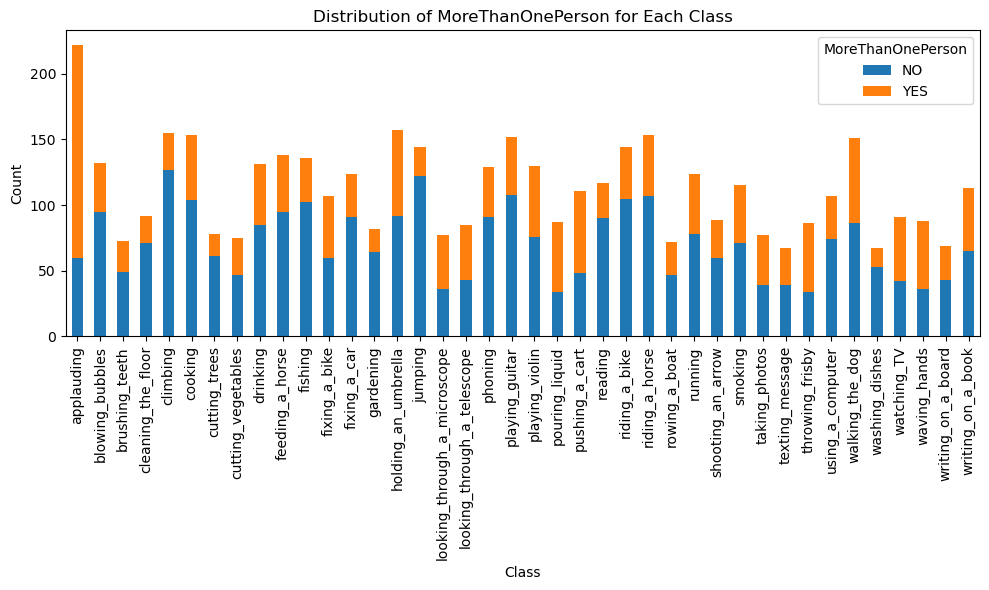

In [13]:
# Group the data and count occurrences
grouped_counts = train_data.groupby(['Class', 'MoreThanOnePerson']).size().reset_index(name='Count')

# Pivot the table to make it suitable for plotting
pivot_table = grouped_counts.pivot(index='Class', columns='MoreThanOnePerson', values='Count').fillna(0)

# Plot the data using the `plot` method
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))  # Adjust figsize for better visualization
ax.set_title('Distribution of MoreThanOnePerson for Each Class')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(pivot_table.index, rotation=90)  # Rotate x-axis labels for readability
ax.legend(title='MoreThanOnePerson')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

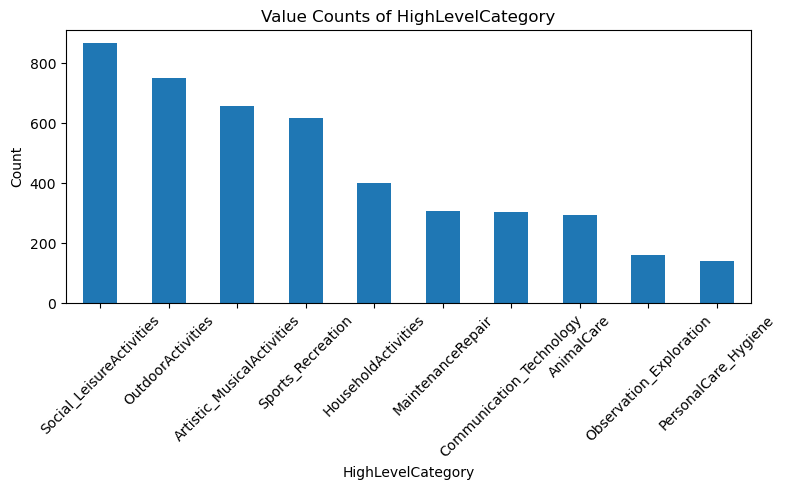

In [14]:
# Count occurrences of each category in 'HighLevelCategory'
category_counts = train_data['HighLevelCategory'].value_counts()

# Plot the bar chart using the `plot` method
ax = category_counts.plot(kind='bar', figsize=(8, 5))  # Adjust figsize for visualization
ax.set_title('Value Counts of HighLevelCategory')
ax.set_xlabel('HighLevelCategory')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Conclusion of the plots**

The imbalance in the MoreThanOnePerson occurrences and the uneven distribution of classes and categories might affect the model’s ability to generalize across different scenarios. This imbalance could be due to varying scene complexities or contexts within each class. To address these issues, several strategies might be employed:

*   **Data Augmentation:** Implementing data augmentation techniques can help balance the occurrences within each class while maintaining a balanced distribution of the MoreThanOnePerson label.
*   **Class Weights Adjustment:** Applying more weight to under-represented classes and less weight to over-represented classes can help mitigate the effects of class imbalance.

These approaches should be considered after evaluating the performance of a baseline model to determine the most effective method for balancing the dataset and improving model accuracy.


## **7. Prepare data for training**

We the target width and height (224x224) for the images. These values are used to resize images, ensuring that they are consistent in size, which is necessary for feeding them into a Convolutional Neural Network (CNN).

In [5]:
# Define the image size for uniformity and compatibility with pre-trained models
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
RANDOM_SEED = 42

In [6]:
# Directory containing the images
image_dir = './Images/'

# Add a column 'FilePath' to store the full file paths of the images for both train and future data
train_data['FilePath'] = train_data['FileName'].apply(lambda filename: os.path.join(image_dir, filename))
future_data['FilePath'] = future_data['FileName'].apply(lambda filename: os.path.join(image_dir, filename))

In [7]:
# Encode the 'Class' column
train_data['Class'], class_mapping = pd.factorize(train_data['Class'])

# Convert 'MoreThanOnePerson' column to binary values (1 for 'YES' and 0 for 'NO')
train_data['MoreThanOnePerson'] = train_data['MoreThanOnePerson'].apply(lambda x: 1 if x == 'YES' else 0)

In [8]:
# Create a mapping for 'MoreThanOnePerson'
binary_mapping = {1: 'YES', 0: 'NO'}

# Save class mapping (index to class name)
class_mapping = {index: label for index, label in enumerate(class_mapping)}

In [9]:
def preprocess_image(path, lbl=None):
    """
    Loads and preprocesses an image from a given file path.
    
    Args:
        path (tf.Tensor): Path to the image file.
        lbl (dict, optional): Dictionary containing labels. Defaults to None.
    
    Returns:
        tf.Tensor or tuple: Preprocessed image, and optionally labels.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_WIDTH, IMAGE_HEIGHT])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    
    if lbl is not None:
        return img, lbl
    else:
        return img

In [10]:
# Split the dataset into training and testing sets
train_set, test_set = train_test_split(
    train_data,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=train_data['Class']
)

val_set, test_set = train_test_split(
    test_set,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=test_set['Class']
)

print(f"Training samples: {len(train_set)}, Testing samples: {len(test_set)}, Validation samples: {len(val_set)}")

Training samples: 3150, Testing samples: 675, Validation samples: 675


In [11]:
# Function to create TensorFlow datasets
def create_tf_dataset(file_paths, labels=None, shuffle_buffer=1000, batch_size=32, is_training=True):
    """
    Creates a TensorFlow dataset from file paths and labels.
    
    Args:
        file_paths (pd.Series): Series containing file paths.
        labels (dict, optional): Dictionary containing labels. Defaults to None.
        shuffle_buffer (int, optional): Buffer size for shuffling. Defaults to 1000.
        batch_size (int, optional): Batch size. Defaults to 32.
        is_training (bool, optional): Whether the dataset is for training. Defaults to True.
    
    Returns:
        tf.data.Dataset: Prepared TensorFlow dataset.
    """
    if labels:
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(file_paths)
        dataset = dataset.map(lambda x: preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training and labels:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [12]:
# Prepare labels as dictionaries
train_labels = {
    'categorical_output': train_set['Class'].values,
    'binary_output': train_set['MoreThanOnePerson'].values
}

test_labels = {
    'categorical_output': test_set['Class'].values,
    'binary_output': test_set['MoreThanOnePerson'].values
}

val_labels = {
    'categorical_output': val_set['Class'].values,
    'binary_output': val_set['MoreThanOnePerson'].values
}

# Create TensorFlow datasets
training_dataset = create_tf_dataset(
    file_paths=train_set['FilePath'],
    labels=train_labels,
    shuffle_buffer=1000,
    batch_size=32,
    is_training=True
)

testing_dataset = create_tf_dataset(
    file_paths=test_set['FilePath'],
    labels=test_labels,
    shuffle_buffer=0,  # No shuffling for validation
    batch_size=32,
    is_training=False
)

validation_dataset = create_tf_dataset(
    file_paths=val_set['FilePath'],
    labels=val_labels,
    shuffle_buffer=0,  # No shuffling for validation
    batch_size=32,
    is_training=False
)

future_dataset = create_tf_dataset(
    file_paths=future_data['FilePath'],
    labels=None,
    shuffle_buffer=0,
    batch_size=32,
    is_training=False
)

#### Inspect dataset to check if loaded correctly

In [27]:
# Function to visualize a batch of images and labels
def inspect_dataset(dataset, dataset_name='Dataset'):
    """
    Inspects a single batch from the dataset by printing shapes and displaying an image.
    
    Args:
        dataset (tf.data.Dataset): TensorFlow dataset to inspect.
        dataset_name (str, optional): Name of the dataset. Defaults to 'Dataset'.
    """
    for batch in dataset.take(1):
        if isinstance(batch, tuple):
            images, labels = batch
            print(f"{dataset_name} - Images shape: {images.shape}")
            print(f"{dataset_name} - Categorical Labels shape: {labels['categorical_output'].shape}")
            print(f"{dataset_name} - Binary Labels shape: {labels['binary_output'].shape}")
            plt.imshow(images[0].numpy())
            plt.title(f"{dataset_name} - Example Image")
            plt.axis('off')
            plt.show()
        else:
            images = batch
            print(f"{dataset_name} - Images shape: {images.shape}")
            plt.imshow(images[0].numpy())
            plt.title(f"{dataset_name} - Example Image")
            plt.axis('off')
            plt.show()

Test Dataset - Images shape: (32, 224, 224, 3)
Test Dataset - Categorical Labels shape: (32,)
Test Dataset - Binary Labels shape: (32,)


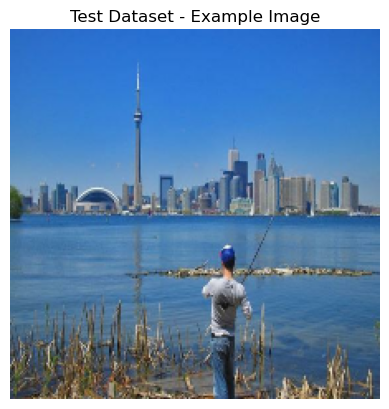

In [28]:
# Inspect the validation dataset
inspect_dataset(validation_dataset, dataset_name='Test Dataset')

Train Dataset - Images shape: (32, 224, 224, 3)
Train Dataset - Categorical Labels shape: (32,)
Train Dataset - Binary Labels shape: (32,)


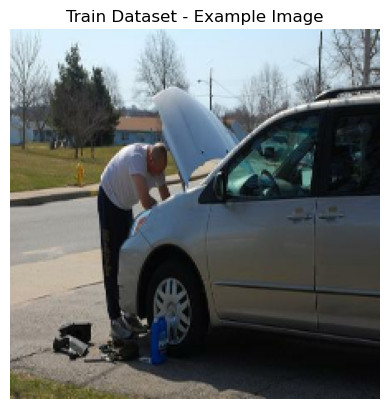

In [29]:
# Inspect the training dataset
inspect_dataset(training_dataset, dataset_name='Train Dataset')

Validation Dataset - Images shape: (32, 224, 224, 3)
Validation Dataset - Categorical Labels shape: (32,)
Validation Dataset - Binary Labels shape: (32,)


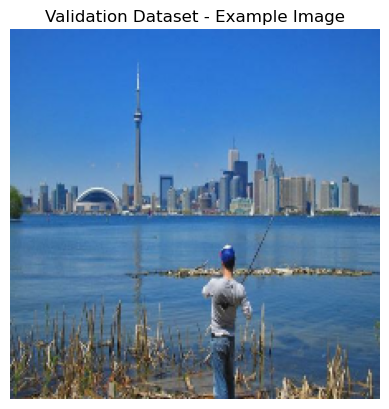

In [30]:
# Inspect the validation dataset
inspect_dataset(validation_dataset, dataset_name='Validation Dataset')

Future Dataset - Images shape: (32, 224, 224, 3)


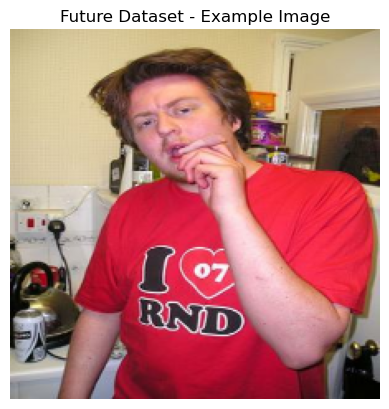

In [31]:
# Inspect the future dataset
for future_batch in future_dataset.take(1):
    print(f"Future Dataset - Images shape: {future_batch.shape}")
    plt.imshow(future_batch[0].numpy())
    plt.title("Future Dataset - Example Image")
    plt.axis('off')
    plt.show()

#### Create helper functions

In [15]:
# Utility function to set up callbacks for model training
def create_callbacks(callback_list=[]):
    """
    Prepares a list of callbacks for model training, including EarlyStopping.
    
    Args:
        callback_list (list, optional): List of additional callbacks to include. Defaults to an empty list.
    
    Returns:
        list: A list of configured callbacks.
    """
    # Initialize a list for the final callbacks
    final_callbacks = []
    
    # Add any provided callbacks
    if callback_list:
        final_callbacks.extend(callback_list)
    
    # Add EarlyStopping callback with patience and best weights restoration
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    final_callbacks.append(early_stop)
    
    return final_callbacks

In [16]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Extract metrics from history object
    train_class_loss = history.history.get('categorical_output_loss', [])
    val_class_loss = history.history.get('val_categorical_output_loss', [])
    train_person_loss = history.history.get('binary_output_loss', [])
    val_person_loss = history.history.get('val_binary_output_loss', [])

    # Plot Loss for Class Output
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, train_class_loss, 'b-', label='Training Loss (Class)')
    plt.plot(epochs, val_class_loss, 'r-', label='Validation Loss (Class)')
    plt.title('Training and Validation Loss (Class Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Loss for Person Output
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, train_person_loss, 'g--', label='Training Loss (Person)')
    plt.plot(epochs, val_person_loss, 'm--', label='Validation Loss (Person)')
    plt.title('Training and Validation Loss (Person Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
def visualize_predictions(model, dataset, class_mapping, num_images=9):
    # Create a mapping from class indices to class names
    idx_to_class = {index: class_name for index, class_name in enumerate(class_mapping)}

    # Prepare the figure for displaying images
    plt.figure(figsize=(12, 12))
    image_count = 0

    for images, labels in dataset.take(1):  # Take one batch from the dataset
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis('off')

            # Get predicted class and person count
            predicted_class = np.argmax(predictions[0][i])
            predicted_person_label = "YES" if predictions[1][i] > 0.5 else "NO"

            if labels is not None:
                true_class = np.argmax(labels[0][i].numpy())
                true_person_label = "YES" if labels[1][i].numpy() == 1 else "NO"
                title = f'True: {idx_to_class[true_class]} | {true_person_label}\nPred: {idx_to_class[predicted_class]} | {predicted_person_label}'
            else:
                title = f'Predicted: {idx_to_class[predicted_class]} | {predicted_person_label}'

            plt.title(title)

            image_count += 1
            if image_count >= num_images:
                break

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()



In [18]:
def plot_confusion_matrices(model, dataset, class_names):
    actual_classes = []
    actual_person_count = []
    predicted_classes = []
    predicted_person_count = []

    # Iterate through the dataset to gather true and predicted labels
    for imgs, lbls in dataset:
        actual_classes.extend(lbls['categorical_output'].numpy())  # True class labels
        actual_person_count.extend(lbls['binary_output'].numpy())  # True binary labels for MoreThanOnePerson
        preds = model.predict(imgs, verbose=0)
        predicted_classes.extend(tf.argmax(preds[0], axis=1).numpy())
        predicted_person_count.extend([1 if p >= 0.5 else 0 for p in preds[1]])

    # Create a subplot with 2 axes for two confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    # Confusion matrix for class predictions
    class_conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    # Generate the list of class names using the class_names mapping
    labels = [class_names[i] for i in range(len(class_names))]

    # Plot heatmap for class prediction confusion matrix
    sns.heatmap(class_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax[0])
    ax[0].set_title('Confusion Matrix - Class Predictions')
    ax[0].set_ylabel('True Class')
    ax[0].set_xlabel('Predicted Class')

    # Confusion matrix for MoreThanOnePerson predictions
    person_conf_matrix = confusion_matrix(actual_person_count, predicted_person_count)
    
    # Plot heatmap for MoreThanOnePerson prediction confusion matrix
    sns.heatmap(person_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NO", "YES"], yticklabels=["NO", "YES"], ax=ax[1])
    ax[1].set_title('Confusion Matrix - MoreThanOnePerson Predictions')
    ax[1].set_ylabel('True Label')
    ax[1].set_xlabel('Predicted Label')

    # Ensure layout is neat
    plt.tight_layout()
    plt.show()

#### Create Baseline Models

In [39]:
def build_baseline_model(units=[16, 32, 64, 64], num_classes=40):
    # Input layer
    inputs = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

    # Convolutional layers with max pooling
    x = tf.keras.layers.Conv2D(units[0], (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(units[1], (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(units[2], (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layer
    x = tf.keras.layers.Dense(units[3], activation='relu')(x)

    # Output layers
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='categorical_output')(x)  # Class output
    person_output = tf.keras.layers.Dense(1, activation='sigmoid', name='binary_output')(x)  # Person output

    # Create and return the model
    model = tf.keras.models.Model(inputs=inputs, outputs=[class_output, person_output])

    return model

In [42]:
# Create the baseline model
baseline_model = build_baseline_model()

# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss={
        'categorical_output': 'sparse_categorical_crossentropy',  # Loss function for class classification
        'binary_output': 'binary_crossentropy'       # Loss function for binary classification
    },
    metrics={
        'categorical_output': 'accuracy',  # Metric for class classification
        'binary_output': tf.keras.metrics.Precision(name='precision')   # Metric for binary classification
    }
)

# Display the model summary
baseline_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 222, 222, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 111, 111, 16  0          ['conv2d_6[0][0]']               
                                )                                                           

#### Train Model

In [43]:
# Create a ReduceLROnPlateau callback to adjust the learning rate
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5,            # Reduce learning rate by a factor of 0.5
    patience=3            # Number of epochs with no improvement to wait before reducing the learning rate
)

# Retrieve additional callbacks
additional_callbacks = create_callbacks([lr_scheduler_callback])

# Train the model with the specified callbacks and validation data
training_history = baseline_model.fit(
    training_dataset,
    epochs=10,
    callbacks=additional_callbacks,
    validation_data=validation_dataset
)


Epoch 1/10
99/99 [==============================] - 17s 51ms/step - loss: 4.3138 - categorical_output_loss: 3.6519 - binary_output_loss: 0.6618 - categorical_output_accuracy: 0.0410 - binary_output_precision: 0.4419 - val_loss: 4.2903 - val_categorical_output_loss: 3.6440 - val_binary_output_loss: 0.6463 - val_categorical_output_accuracy: 0.0356 - val_binary_output_precision: 0.3333 - lr: 0.0010
Epoch 2/10
99/99 [==============================] - 4s 37ms/step - loss: 4.1519 - categorical_output_loss: 3.5182 - binary_output_loss: 0.6337 - categorical_output_accuracy: 0.0851 - binary_output_precision: 0.6074 - val_loss: 4.1168 - val_categorical_output_loss: 3.4855 - val_binary_output_loss: 0.6313 - val_categorical_output_accuracy: 0.0993 - val_binary_output_precision: 0.5287 - lr: 0.0010
Epoch 3/10
99/99 [==============================] - 4s 37ms/step - loss: 3.7357 - categorical_output_loss: 3.1467 - binary_output_loss: 0.5890 - categorical_output_accuracy: 0.1635 - binary_output_precis

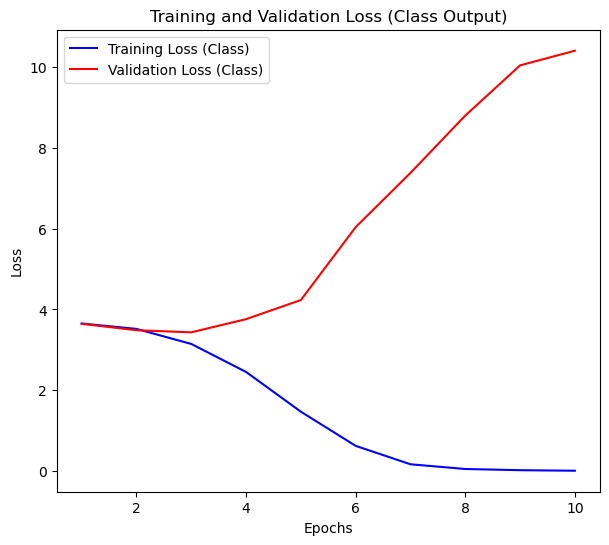

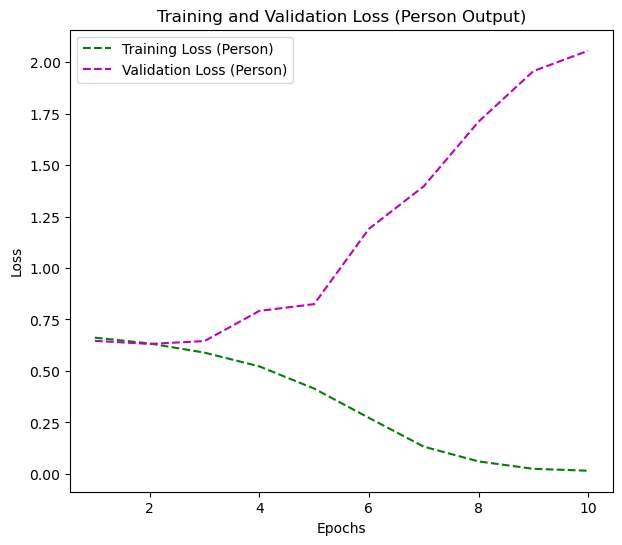

In [46]:
plot_training_history(training_history)

Model is overfitting. This is to be expected because of the small amount of data the dataset has to offered. Therefore, we will leverage transfer learning to fix the model's overfitting. Additionally, usign transfer learning will also alleviate the effects of unbalanced data

In [13]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x)  

output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

pretrained = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

pretrained.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['xception[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

In [19]:
history = pretrained.fit(
    training_dataset,
    epochs=10,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/10
99/99 [==============================] - 94s 574ms/step - loss: 2.6752 - categorical_output_loss: 2.0631 - binary_output_loss: 0.6120 - categorical_output_accuracy: 0.4759 - binary_output_precision: 0.5900 - val_loss: 1.7557 - val_categorical_output_loss: 1.1986 - val_binary_output_loss: 0.5571 - val_categorical_output_accuracy: 0.6667 - val_binary_output_precision: 0.8125 - lr: 0.0010
Epoch 2/10
99/99 [==============================] - 52s 497ms/step - loss: 1.4445 - categorical_output_loss: 0.9348 - binary_output_loss: 0.5096 - categorical_output_accuracy: 0.7378 - binary_output_precision: 0.7452 - val_loss: 1.5359 - val_categorical_output_loss: 1.0245 - val_binary_output_loss: 0.5114 - val_categorical_output_accuracy: 0.6948 - val_binary_output_precision: 0.7083 - lr: 0.0010
Epoch 3/10
64/99 [==================>...........] - ETA: 14s - loss: 1.1685 - categorical_output_loss: 0.6858 - binary_output_loss: 0.4826 - categorical_output_accuracy: 0.8066 - binary_output_precisi

KeyboardInterrupt: 

In [ ]:
plot_training_history(history)

In [ ]:
visualize_predictions(pretrained, validation_dataset, class_mapping)

Using transfer learning where able to improve the situation somewhat, raising the validation accuracy for both outputs. However, the model is still overfitting. Therefore, we need more sophisticated methods to prevent overfitting

One thing I noticed from the visualizing the predictions was the model often confuse between different classes if an image contain objects that signifies that class. For example, in an image where the main person is smoking, if in the near parameter there is an umbrella, then the model would confuse between smoking and holding an umbrella. Therefore, my intuition is having a way for the model to learn the most important part of the image for predicting the categorical class, which in this case is the main person. If we look at the image, the main class for each image can be recognized by looking at the person appears biggest in the image. Therefore, the model needs to learn how to prioritize the main person in the image.

One of the ideas was proposed in this paper: https://arxiv.org/pdf/1803.10704 which introduced attention modules might help with this. These modules allow for learning of taskspecific features from the global features, whilst simultaneously allowing for features to be shared across different tasks. The architecture can be trained end-to-end and can be built upon any feed-forward neural network, is simple to implement, and is parameter efficient

There are many implementations of the channel attention module, but specifically, I will use the version specified in this paper https://arxiv.org/abs/2003.09893, as the paper benchmark using the same dataset and achieved relatively good performance. Additionally, the backbone model I use for the model is the same as the one tested in the paper. Although the best model was NASNet, because of the limited computing power, I will use the smaller model but achieved high result in terms of accuracy, which is Xception

In [ ]:
# Implement channel attention module
def attetion_module(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_1 = layers.Dense(channel // ratio, kernel_initializer='he_normal',)
    
    shared_2 = layers.Dense(channel, kernel_initializer='he_normal',)
    
    x = layers.GlobalAveragePooling2D()(input_feature)
    
    x = shared_1(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = shared_2(x)
    x = layers.Activation('relu')(x)
    
    return layers.Multiply()([input_feature, x])

Similar to the model architecture mentioned in the paper: https://arxiv.org/abs/2003.09893, my model will also have the same classification section as the paper. Of course, with modifications to suit our specific problem

In [20]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)
x = attetion_module(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

x1 = layers.Dropout(0.4)(x)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)  

x2 = layers.Dropout(0.4)(x)
x2 = layers.Dense(64, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_with_attention = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_with_attention.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_with_attention.summary()

NameError: name 'attetion_module' is not defined

In [ ]:
history = model_with_attention.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

In [ ]:
plot_training_history(history)

Using the attention module, the model was able to converge a good result faster. Additionally, the model was able to reduce overfitting, although the second output is still overfitting. Therefore, to reduce overfitting, we will reduce model's complexity. Specifically, I will reduce the complexity in the second branch, as the first branch is not overfitting

#### Reduce overfitting

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)
x = attetion_module(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

x1 = layers.Dropout(0.4)(x)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)  

x2 = layers.Dropout(0.4)(x)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(16, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_1 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_1.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_1.summary()

In [ ]:
history = model_1.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

#### Atrous Convolution

One thing I noticed is the while the first output accuracy were increasing, the second output accuracy stopped growing after it reached a value. My rationale is the feature required by the second output is different from the first output. Since the second output is predicting if an image has more than one person, it would need to look at larger view of the image, which is not the same case for the first output. The first output needs to predict the classes of the dominant person in the image, therefore it will need to look at a smaller view of the image. Thus, I will use the channel attention module on the first branch only, while for the second output will have atrous convolution

In [ ]:
def atrous_conv_layer(inputs, filters, kernel_size, rate):
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
    dilation_rate=rate, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x1 = attetion_module(x)
x1 = layers.GlobalAveragePooling2D()(x)
x1 = layers.Dense(128, activation='relu')(x)
x1 = layers.Dropout(0.4)(x)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)  

x2 = atrous_conv_layer(x, 32, (7, 7), rate=2)
x2 = atrous_conv_layer(x2, 32, (7, 7), rate=4)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.4)(x)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(16, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_2 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_2.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_2.summary()

In [ ]:
history = model_2.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

In [ ]:
plot_training_history(history)

#### Reduce overfitting if still exists TODO